This tutorial demonstrates Gaussian process inference on data structured on a grid in the general case where gaps are present.
In the special case were no data is missing, see `full_grid_tutorial.ipynb`.

In [1]:
%matplotlib inline
import numpy as np
import gp_grid
import matplotlib.pyplot as plt
from gp_grid.misc import rastrigin, grid2mat, gapify_data, elastic_membrane

# Two-Dimensional Gridded Dataset with Missing Values
We will consider a two-dimensional synthetic dataset (the Rastrigin function) for visualization and randomly remove 40% of the data for training.

In [2]:
np.random.seed(0)
d = 2

# generate the training set
n = 30 # number of points along each dimension
N_missing = np.int32(np.floor(0.40*n**d))
xg = [np.linspace(0,1,num=n).reshape((-1,1)),]*d
x = grid2mat(*xg)
y = rastrigin((x*2-1)*5.12)
gaps = np.random.choice(y.shape[0], size=N_missing, replace=False) # randomly set some data to nan
y[gaps] = np.nan
yg = y.reshape((n,)*d)

# generate the test set
nn = 100 # number of test points along each dimension
xxg = [np.linspace(0,1,num=nn).reshape((-1,1)),]*d
xx = grid2mat(*xxg) 
yy = rastrigin((xx*2-1)*5.12)

We can now fit a model to this data set and plot the whole image (also at a higher resolution).
Because the data lies on a grid, GP inference can be performed extremely efficiently even though there are gaps in the dataset. 
This approach can easily extended to higher dimensional input grids.

[ 13:30:48 ] gp_grid.models INFO: Function Evals: 16. Log-Marginal Likelihood: -2344.12.


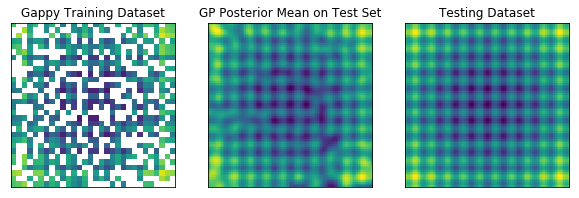

In [3]:
# initialize the kernel and the GP model
kern_list = [gp_grid.kern.RBF(1, lengthscale=0.05, variance=30.) for i in range(d)]
m = gp_grid.models.GPGappyRegression(xg,yg,kern_list,noise_var=1e-6)
m.optimize() # estimate the hyperparameters through log-marginal likelihood maximization

# plot the training data, the model prediction, and the testing data
fig, ax = plt.subplots(ncols=3, figsize=(10,4)) 
yyh = m.predict_grid(xxg) # the model prediction
ax[0].imshow(yg,interpolation='none',vmin=yy.min(), vmax=yy.max())
ax[0].set_title('Gappy Training Dataset')
ax[1].imshow(yyh.reshape((nn,)*d),interpolation='none',vmin=yy.min(), vmax=yy.max())
ax[1].set_title("GP Posterior Mean on Test Set")
ax[2].imshow(yy.reshape((nn,)*d),interpolation='none',vmin=yy.min(), vmax=yy.max())
ax[2].set_title('Testing Dataset')
for i in range(len(ax)): # remove ticks from figures to make pretty
    ax[i].tick_params(which='both', bottom=False, top=False, left=False, right=False, 
                       labelbottom=False,labelleft=False)

The quality of the reconstruction looks reasonable given the data.
This is a very scalable approach that has been used to perform exact GP inference using datasets with over 1 billion points.

# Identifying Structure by Grouping Dimensions
Here we will discuss identifying non-obvious structure in a dataset by grouping dimensions together to form a grid.
We will consider a spatial-temporal problem of a resonating elastic membrane.
We want to build a model to predict the displacement of the membrane at a specific point in space and time, however, we only observe the data at few scattered (i.e. non-gridded) locations at each temporal snapshot.
In this case, the dataset still forms a spatial-temporal grid by considering that the two-spatial dimensions together form an single dimension of the grid.

First we will generate the dataset and then plot a few temporal snapshots of the membrane's displacement.
We will also randomly remove some of the training observations so that our grid will be gappy.

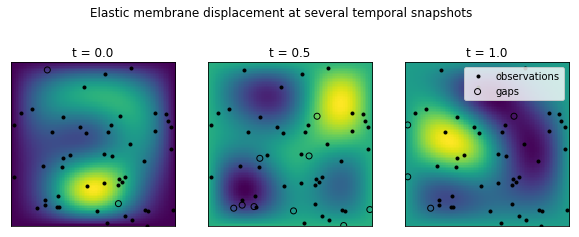

In [4]:
np.random.seed(0)
n_p, n_q = 3, 3 # number of vertical/horizontal waves

# get random coefficients (corresponding to random initial conditions of the membrane)
F = np.random.normal(size=(n_p,1))
H = np.random.normal(size=(n_q,1))
C = np.random.normal(size=(n_p,n_q))
D = np.random.normal(size=(n_p,n_q))

# get a grid of displacements for testing
nn = (100, 100, 3) # test grid dimensions
xxg=[np.linspace(0,1,num=ni).reshape(-1,1) for ni in nn[:2]] + \
    [np.linspace(0,1,num=nn[2]).reshape(-1,1),]
xx = grid2mat(*xxg) # convert from grid to actual points
zzg = elastic_membrane(x=xx[:,(0,)], y=xx[:,(1,)], t=xx[:,(2,)],
                     F=F, H=H, C=C, D=D, lx=1, ly=1, v=1).reshape(nn)

# get the spatially scattered training dataset (still forms a grid beteen space/time)
n = (50, 3) # (num-scattered-spatial-points, num-temporal-snapshots)
xg = [np.random.rand(n[0],2), xxg[2]]
x = np.block([[xg[0], xg[1][i]+np.zeros((n[0],1))] for i in range(3)])
z = elastic_membrane(x=x[:,(0,)], y=x[:,(1,)], t=x[:,(2,)],
                     F=F, H=H, C=C, D=D, lx=1, ly=1, v=1)

# randomly set some training data and set to nan
gaps = np.random.choice(z.shape[0], size=np.int32(np.floor(0.1*z.shape[0])), replace=False)
z[gaps] = np.nan
zg = z.reshape(n,order="F") # reshape into the gridded form

# plot the training and test dataset
fig, ax = plt.subplots(ncols=3, figsize=(10,4))
for i in range(3):
    ax[i].imshow(zzg[:,:,i], interpolation='none', origin='lower', extent=(0,1,0,1))
    ax[i].plot(xg[0][np.logical_not(np.isnan(zg[:,i])),0], 
               xg[0][np.logical_not(np.isnan(zg[:,i])),1], 'k.', label="observations")
    ax[i].scatter(xg[0][np.isnan(zg[:,i]),0], 
                  xg[0][np.isnan(zg[:,i]),1], facecolors='none', 
                  edgecolors='k', label='gaps')
    ax[i].set_title("t = %.1f"%xxg[2][i])
    ax[i].tick_params(which='both', bottom=False, top=False, left=False, right=False, 
                       labelbottom=False,labelleft=False)
    ax[i].set_xlim([0,1]); ax[i].set_ylim([0,1])
    if i == 2: ax[i].legend(loc=0)
fig.suptitle("Elastic membrane displacement at several temporal snapshots");

Now we can build the GP to reconstruct the membrane displacement

[ 13:30:50 ] gp_grid.models INFO: Function Evals: 69. Log-Marginal Likelihood: 30.3822.


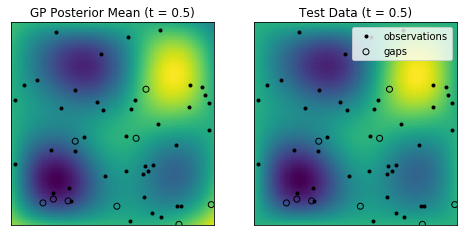

In [5]:
# initialize the kernel, note that the first 'grid dimension' is 2
kern_list = [gp_grid.kern.RBF(2, lengthscale=1.), gp_grid.kern.RBF(1, lengthscale=0.3)]

# now initialize the model
m = gp_grid.models.GPGappyRegression(xg,zg,kern_list,noise_var=1e-6)
m.optimize() # estimate the hyperparameters through log-marginal likelihood maximization

# predict the posterior mean at the test set locations
zzh = m.predict_grid([grid2mat(xxg[0],xxg[1]), xxg[2]]) # the model prediction

# plot the middle snapshot (t=0.5) and compare to the test set
fig, ax = plt.subplots(ncols=2, figsize=(8,4))
ax[0].imshow(zzh[:,1].reshape(nn[:2]), interpolation='none', origin='lower', 
             extent=(0,1,0,1), vmax=zzg[:,:,1].max(), vmin=zzg[:,:,1].min())
ax[0].set_title("GP Posterior Mean (t = %.1f)"%xxg[2][1])
ax[1].imshow(zzg[:,:,1], interpolation='none', origin='lower', extent=(0,1,0,1))
ax[1].set_title("Test Data (t = %.1f)"%xxg[2][1])

# plot the training data locations
for i in range(2):
    ax[i].plot(xg[0][np.logical_not(np.isnan(zg[:,1])),0], 
               xg[0][np.logical_not(np.isnan(zg[:,1])),1], 'k.', label="observations")
    ax[i].scatter(xg[0][np.isnan(zg[:,1]),0], 
                  xg[0][np.isnan(zg[:,1]),1], facecolors='none', 
                  edgecolors='k', label='gaps')
    ax[i].tick_params(which='both', bottom=False, top=False, left=False, right=False, 
                       labelbottom=False,labelleft=False)
    ax[i].set_xlim([0,1]); ax[i].set_ylim([0,1])
    if i == 1: ax[i].legend(loc=0)

You can see that the quality reconstruction is quite good.
There are many real-world problems where this gridded stucture can be identified and exploited to build fast and scalable exact Gaussian process models.